In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt
import random
from minigrid.wrappers import RGBImgObsWrapper
from tqdm import tqdm
import math
import pygame
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Goal, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
import random
from minigrid.wrappers import RGBImgObsWrapper
from env import FourRoomsEnv

pygame 2.5.2 (SDL 2.28.3, Python 3.11.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Initialize the FourRooms environment
env = FourRoomsEnv()

# Wrap the environment to return RGB images as observations
env = RGBImgObsWrapper(env)

# Define the action space size (number of possible actions)
action_space = 3

# Define the observation space shape (dimensions of the observation image)
obs_space = env.observation_space['image'].shape

# Check if CUDA (GPU) is available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set various hyperparameters for the training process
horizon_scale = 0.02       # Scale factor for the horizon
return_scale = 0.02        # Scale factor for the return
replay_size = 1000000       # Size of the replay buffer
n_warm_up_episodes = 50    # Number of warm-up episodes before training
n_updates_per_iter = 150   # Number of updates per iteration
n_episodes_per_iter = 15   # Number of episodes per iteration
last_few = 50              # Number of last episodes to consider for performance evaluation
batch_size = 32            # Batch size for training

# Print the observation space, action space, and device information
print(f"Observation space: {obs_space}")
print(f"Action space: {action_space}")
print(f"Device: {device}")


Observation space: (104, 104, 3)
Action space: 3
Device: cuda:0


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

class BF(nn.Module):
    def __init__(self, obs_space, action_space, hidden_size, seed):
        super(BF, self).__init__()
        torch.manual_seed(seed)

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        # Calculate the output size of the convolutional layers
        conv_output_size = self._get_conv_output_size(obs_space)
        
        # Fully connected layer for image features
        self.fc1 = nn.Linear(conv_output_size, hidden_size)
        
        # Fully connected layer for command input
        self.commands = nn.Linear(2, hidden_size)
        
        # Combined fully connected layers
        self.fc_comb = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_space)

    def _get_conv_output_size(self, obs_space):
        # Helper function to determine the size of the output from conv layers
        with torch.no_grad():
            input = torch.zeros(1, obs_space[2], obs_space[0], obs_space[1])
            output = self.conv1(input)
            output = self.relu(output)
            output = self.conv2(output)
            output = self.relu(output)
            output = self.pool(output)
            output = output.view(1, -1)
        return output.size(1)
        
    def forward(self, state, command):
        # Forward pass through convolutional layers
        state = self.relu(self.conv1(state))
        state = self.relu(self.conv2(state))
        state = self.pool(state)
        state = state.view(state.size(0), -1)
        
        # Forward pass through fully connected layers for state and command
        state_out = self.relu(self.fc1(state))
        command_out = self.relu(self.commands(command))
        
        # Combine state and command outputs and pass through combined layers
        combined = torch.cat((state_out, command_out), dim=1)
        combined = self.relu(self.fc_comb(combined))
        combined = self.relu(self.fc2(combined))
        
        # Output layer for action probabilities
        action_probs = self.fc3(combined)
        return action_probs

    def action(self, state, desire, horizon):
        # Create command input and get action probabilities
        command = torch.cat((desire * return_scale, horizon * horizon_scale), dim=-1).unsqueeze(0)
        action_prob = self.forward(state, command)
        
        # Sample an action based on the probabilities
        probs = torch.softmax(action_prob, dim=-1)
        m = Categorical(probs)
        action = m.sample()
        return action
    
    def greedy_action(self, state, desire, horizon):
        # Create command input and get action probabilities
        command = torch.cat((desire * return_scale, horizon * horizon_scale), dim=-1).unsqueeze(0)
        action_prob = self.forward(state, command)
        
        # Get the action with the highest probability
        probs = torch.softmax(action_prob, dim=-1)
        action = torch.argmax(probs).item()
        return action


In [4]:
class ReplayBuffer():
    def __init__(self, max_size):
        # Initialize the replay buffer with a maximum size
        self.max_size = max_size
        self.buffer = []

    def add_sample(self, states, actions, rewards):
        # Add a sample (episode) to the buffer
        episode = {"states": states, "actions": actions, "rewards": rewards, "summed_rewards": sum(rewards)}
        self.buffer.append(episode)
        
        # If the buffer exceeds the maximum size, keep only the top episodes based on summed rewards
        if len(self.buffer) > self.max_size:
            self.buffer.sort(key=lambda i: i["summed_rewards"], reverse=True)
            self.buffer = self.buffer[:self.max_size]

    def get_random_samples(self, batch_size):
        # Retrieve a random sample of episodes from the buffer
        if batch_size > len(self.buffer):
            raise ValueError("Batch size larger than buffer size.")
        return random.sample(self.buffer, batch_size)

    def get_nbest(self, n):
        # Retrieve the top n episodes based on summed rewards
        if n > len(self.buffer):
            raise ValueError("n is larger than buffer size.")
        self.buffer.sort(key=lambda i: i["summed_rewards"], reverse=True)
        return self.buffer[:n]

    def __len__(self):
        # Return the current size of the buffer
        return len(self.buffer)


In [5]:
import numpy as np
import torch.optim as optim

# Initialize the replay buffer with a specified size
buffer = ReplayBuffer(replay_size)

# Create the neural network (BF) and move it to the appropriate device (CPU or GPU)
bf = BF(obs_space, action_space, 64, 1).to(device)

# Define the optimizer for the neural network
optimizer = optim.Adam(params=bf.parameters(), lr=1e-3)

# List to store samples
samples = []

# Initialize desired reward and time horizon
init_desired_reward = 5
init_time_horizon = 200 

# Warm-up phase to populate the replay buffer with initial episodes
for i in range(n_warm_up_episodes):
    desired_return = torch.FloatTensor([init_desired_reward])
    desired_time_horizon = torch.FloatTensor([init_time_horizon])
    obs, _ = env.reset()  # Reset the environment and get initial observation
    state = obs['image']
    states = []
    actions = []
    rewards = []
    step = 0
    total_reward = 0

    while True:
        # Convert state to tensor and move it to the appropriate device
        state_tensor = torch.from_numpy(state).float().permute(2, 0, 1).to(device)
        
        # Choose an action based on the current state, desired return, and time horizon
        action = bf.action(state_tensor.unsqueeze(0).to(device), desired_return.to(device), desired_time_horizon.to(device)).item()
        
        # Take a step in the environment
        next_obs, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        next_state = next_obs['image']
        
        # Print the step information for debugging
        print(f"Step {step}: Action = {action}, TotalReward = {total_reward:.2f}, Done = {done}, Truncated = {truncated}")
        step += 1

        # Store the state, action, and reward
        states.append(state_tensor.cpu().numpy()) 
        actions.append(action)
        rewards.append(reward)

        # Update the current state
        state = next_state

        # Update desired return and time horizon
        desired_return -= reward
        desired_time_horizon -= 1
        desired_time_horizon = torch.FloatTensor([np.maximum(desired_time_horizon, 1).item()])

        # Check if the episode is done or truncated
        if done or truncated:
            break

    # Add the collected episode to the replay buffer
    buffer.add_sample(states, actions, rewards)


C:\python\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


Step 0: Action = 2, TotalReward = 0.90, Done = False, Truncated = False
Step 1: Action = 2, TotalReward = 1.80, Done = False, Truncated = False
Step 2: Action = 2, TotalReward = 2.70, Done = False, Truncated = False
Step 3: Action = 2, TotalReward = 1.60, Done = False, Truncated = False
Step 4: Action = 2, TotalReward = 1.50, Done = False, Truncated = False
Step 5: Action = 2, TotalReward = 1.40, Done = False, Truncated = False
Step 6: Action = 1, TotalReward = 1.30, Done = False, Truncated = False
Step 7: Action = 2, TotalReward = 1.20, Done = False, Truncated = False
Step 8: Action = 0, TotalReward = 1.10, Done = False, Truncated = False
Step 9: Action = 2, TotalReward = 1.00, Done = False, Truncated = False
Step 10: Action = 2, TotalReward = 0.90, Done = False, Truncated = False
Step 11: Action = 2, TotalReward = 0.80, Done = False, Truncated = False
Step 12: Action = 1, TotalReward = 0.70, Done = False, Truncated = False
Step 13: Action = 1, TotalReward = 0.60, Done = False, Trunca

In [6]:
## OBSERVE THE WEIGHTS before training
for p in bf.parameters():
    print(p)

Parameter containing:
tensor([[[[ 0.0992, -0.0849, -0.0373],
          [ 0.0903, -0.1812,  0.1154],
          [-0.0396,  0.0979,  0.0268]],

         [[-0.0236,  0.0534,  0.0095],
          [ 0.0703, -0.0750, -0.0140],
          [-0.0173,  0.0279, -0.0008]],

         [[ 0.1682,  0.0599, -0.0717],
          [-0.1162, -0.0323, -0.0830],
          [-0.0617,  0.0092,  0.1147]]],


        [[[ 0.1046, -0.1881,  0.1193],
          [ 0.0538,  0.1825,  0.1270],
          [-0.1753, -0.1830, -0.0928]],

         [[ 0.1690, -0.0321,  0.0824],
          [-0.0894,  0.1888, -0.0814],
          [ 0.1443,  0.0023, -0.1014]],

         [[ 0.0989, -0.1022,  0.0566],
          [-0.0556, -0.0211, -0.1850],
          [-0.0918,  0.1044, -0.0468]]],


        [[[ 0.1917,  0.1543, -0.0090],
          [-0.1285,  0.1172,  0.0597],
          [-0.1244,  0.1250,  0.1168]],

         [[ 0.1707, -0.1079, -0.0317],
          [-0.0037,  0.0281, -0.1461],
          [-0.1366,  0.1047, -0.0451]],

         [[ 0.0940,  0

In [7]:
# FUNCTIONS FOR Sampling exploration commands
def sampling_exploration(top_X_eps=last_few):
    """
    This function calculates the new desired reward and new desired horizon based on the replay buffer.
    New desired horizon is calculated by the mean length of the best last X episodes. 
    New desired reward is sampled from a uniform distribution given the mean and the std calculated from the last best X performances.
    where X is the hyperparameter last_few.
    """
    if len(buffer) < top_X_eps:
        raise ValueError("Not enough episodes in the buffer to sample from.")

    top_X = buffer.get_nbest(top_X_eps)
    if not top_X:
        return torch.FloatTensor([0]), torch.FloatTensor([0])  # Default or minimal values if no data is available

    # The exploratory desired horizon dh0 is set to the mean of the lengths of the selected episodes
    new_desired_horizon = np.mean([len(i["states"]) for i in top_X])
    # Save all top_X cumulative returns in a list 
    returns = [i["summed_rewards"] for i in top_X]
    # From these returns calculate the mean and std
    mean_returns = np.mean(returns)
    std_returns = np.std(returns)
    # Sample desired reward from a uniform distribution given the mean and the std
    new_desired_reward = np.random.uniform(mean_returns, mean_returns + std_returns)

    return torch.FloatTensor([new_desired_reward]), torch.FloatTensor([new_desired_horizon])

In [8]:
# FUNCTIONS FOR TRAINING
def select_time_steps(saved_episode):
    """
    Given a saved episode from the replay buffer, this function samples random time steps (t1 and t2) in that episode:
    T = max time horizon in that episode.
    Returns t1, t2, and T. Ensures that t1 and t2 are different and t1 < t2.
    """
    T = len(saved_episode["states"])  # episode max horizon
    t1 = np.random.randint(0, T - 1)  # Ensure there is at least one step after t1
    t2 = np.random.randint(t1 + 1, T)  # Ensure t2 is after t1

    return t1, t2, T

def create_training_input(episode, t1, t2):
    """
    Based on the selected episode and the given time steps, this function returns 4 values:
    1. state at t1
    2. the desired reward: sum over all rewards from t1 to t2 (exclusive)
    3. the time horizon: t2 - t1
    4. the target action taken at t1
    
    Buffer episodes are structured as [cumulative episode reward, states, actions, rewards].
    """
    state = episode["states"][t1]
    desired_reward = sum(episode["rewards"][t1:t2])
    time_horizon = t2 - t1
    action = episode["actions"][t1]
    
    return state, desired_reward, time_horizon, action

def create_training_examples(batch_size):
    """
    Creates a data set of training examples that can be used to create a data loader for training.
    ============================================================
    1. For the given batch_size, episode indices are randomly selected.
    2. Based on these episodes, t1 and t2 are sampled for each selected episode.
    3. For the selected episode and sampled t1 and t2, training values are gathered.
    ______________________________________________________________
    Output are four lists of length batch_size:
    states, rewards, horizons, and actions.
    """
    states = []
    rewards = []
    horizons = []
    actions = []
    episodes = buffer.get_random_samples(batch_size)
    
    for ep in episodes:
        t1, t2, T = select_time_steps(ep)
        t2 = T
        state, desired_reward, time_horizon, action = create_training_input(ep, t1, t2)
        

        states.append(torch.FloatTensor(state))
        rewards.append(torch.FloatTensor([desired_reward]))
        horizons.append(torch.FloatTensor([time_horizon]))
        actions.append(torch.tensor(action, dtype=torch.long))
        
    
    # print("Number of states:", len(states))
    # print("Number of rewards:", len(rewards))
    # print("Number of horizons:", len(horizons))
    # print("Number of actions:", len(actions))
    
    # for i in range(len(states)):
    #      print(f"State {i}: shape {states[i].shape}, type {type(states[i])}")
    # for i in range(len(states)):  
    #      print(f"Reward {i}: shape {rewards[i].shape}, type {type(rewards[i])}")
    # for i in range(len(states)):
    #      print(f"Horizon {i}: shape {horizons[i].shape}, type {type(horizons[i])}")
    # for i in range(len(states)):
    #      print(f"Action {i}: shape {actions[i].shape}, type {type(actions[i])}")

    return states, rewards, horizons, actions

def train_behavior_function(batch_size):
    """
    Trains the BF with on a cross entropy loss where the inputs are the action probabilities based on the state and command.
    The targets are the actions appropriate to the states from the replay buffer.
    """
    states, rewards, horizons, actions = create_training_examples(batch_size)

    # Convert lists to tensors and move them to the appropriate device
    state_tensors = torch.stack(states).to(device)
    reward_tensors = torch.stack(rewards).to(device)
    horizon_tensors = torch.stack(horizons).to(device)
    action_tensors = torch.stack(actions).to(device)
    
    # print("State Tensor:          ", state_tensors.shape)
    # print("\tRewards tensor:      ", reward_tensors.shape)
    # print("\tHorizons tensor:     ", horizon_tensors.shape)
    # print("\tActions tensor:      ", action_tensors.shape)

    # Ensure reward_tensors and horizon_tensors have correct shape for concatenation
    command = torch.cat((reward_tensors, horizon_tensors), dim=1)
    # Run model
    outputs = bf(state_tensors, command).float()
    # print("Outputs: ", outputs , "Action Tensors: ", action_tensors)
    # Compute cross entropy loss
    loss = F.cross_entropy(outputs, action_tensors)

    # Optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [9]:
def evaluate(desired_return, desired_time_horizon):
    """
    Runs one episode of the environment to evaluate the behavior function (bf).
    
    Args:
        desired_return (torch.FloatTensor): The desired return for the episode.
        desired_time_horizon (torch.FloatTensor): The desired time horizon for the episode.
    
    Returns:
        total_rewards (float): The total rewards accumulated during the episode.
    """
    # Reset the environment and get the initial observation
    obs, _ = env.reset()
    state = obs['image']
    total_rewards = 0

    while True:
        # Convert state to tensor, add batch dimension, and move to device
        state_tensor = torch.from_numpy(state).float().permute(2, 0, 1).unsqueeze(0).to(device)
        
        # Choose an action using the behavior function based on current state, desired return, and time horizon
        action = bf.action(state_tensor, desired_return.to(device), desired_time_horizon.to(device)).item()
        
        # Take a step in the environment
        next_obs, reward, done, truncated, _ = env.step(action)
        next_state = next_obs['image']
        
        # Accumulate rewards
        total_rewards += reward
        
        # Update the current state
        state = next_state
        
        # Update desired return and time horizon
        desired_return -= reward
        desired_time_horizon -= 1
        desired_time_horizon = torch.FloatTensor([max(desired_time_horizon.item(), 1)])
        
        # Check if the episode is done or truncated
        if done or truncated:
            break
            
    return total_rewards


In [10]:
def generate_episode(desired_return=torch.FloatTensor([init_desired_reward]), desired_time_horizon=torch.FloatTensor([init_time_horizon])):    
    """
    Generates an episode using the behavior function and adds it to the replay buffer.
    
    Args:
        desired_return (torch.FloatTensor): The desired return for the episode.
        desired_time_horizon (torch.FloatTensor): The desired time horizon for the episode.
    
    Returns:
        list: A list containing states, actions, and rewards for the episode.
    """
    obs, _ = env.reset()
    state = obs['image']
    states = []
    actions = []
    rewards = []
    
    while True:
        # Convert state to tensor and move to the appropriate device
        state_tensor = torch.from_numpy(state).float().permute(2, 0, 1).to(device)
        
        # Choose an action using the behavior function based on current state, desired return, and time horizon
        action = bf.action(state_tensor.unsqueeze(0).to(device), desired_return.to(device), desired_time_horizon.to(device)).item()
        
        # Take a step in the environment
        next_obs, reward, done, truncated, _ = env.step(action)
        next_state = next_obs['image']
        
        # Store the state, action, and reward
        states.append(state_tensor.cpu().numpy())
        actions.append(action)
        rewards.append(reward)
        
        # Update the current state
        state = next_state
        
        # Update desired return and time horizon
        desired_return -= reward
        desired_time_horizon -= 1
        desired_time_horizon = torch.FloatTensor([np.maximum(desired_time_horizon.item(), 1)])
        
        # Check if the episode is done
        if done or truncated:
            break

    # Ensure the episode has at least 2 steps
    if len(states) < 2:
        return generate_episode(desired_return, desired_time_horizon)
    
    return [states, actions, rewards]

def run_upside_down(max_episodes):
    """
    Runs the Upside-Down Reinforcement Learning algorithm.
    
    Args:
        max_episodes (int): The maximum number of episodes to run.
    
    Returns:
        tuple: Contains lists of all rewards, average rewards over the last 100 episodes, desired rewards history, horizon history, and losses.
    """
    all_rewards = []
    losses = []
    average_100_reward = []
    desired_rewards_history = []
    horizon_history = []
    
    for ep in tqdm(range(1, max_episodes + 1), desc="Training Progress"):
        # Improve|optimize the behavior function based on the replay buffer
        loss_buffer = []
        for i in range(n_updates_per_iter):
            bf_loss = train_behavior_function(batch_size)
            loss_buffer.append(bf_loss)
        bf_loss = np.mean(loss_buffer)
        losses.append(bf_loss)

        # Run new episodes and add to buffer
        for i in range(n_episodes_per_iter):
            # Sample exploratory commands based on buffer
            new_desired_reward, new_desired_horizon = sampling_exploration()
            generated_episode = generate_episode(new_desired_reward, new_desired_horizon)
            buffer.add_sample(generated_episode[0], generated_episode[1], generated_episode[2])

        # Monitor desired reward and desired horizon
        new_desired_reward, new_desired_horizon = sampling_exploration()
        desired_rewards_history.append(new_desired_reward.item())
        horizon_history.append(new_desired_horizon.item())

        # Evaluate the behavior function with new exploratory commands
        ep_rewards = evaluate(new_desired_reward, new_desired_horizon)
        all_rewards.append(ep_rewards)
        average_100_reward.append(np.mean(all_rewards[-100:]))

        # Print progress
        print("\rEpisode: {} | Rewards: {:.2f} | Mean_100_Rewards: {:.2f} | Loss: {:.2f}".format(
            ep, ep_rewards, np.mean(all_rewards[-100:]), bf_loss), end="", flush=True)
        if ep % 100 == 0:
            print("\rEpisode: {} | Rewards: {:.2f} | Mean_100_Rewards: {:.2f} | Loss: {:.2f}".format(
                ep, ep_rewards, np.mean(all_rewards[-100:]), bf_loss))

    return all_rewards, average_100_reward, desired_rewards_history, horizon_history, losses


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Total Reward: -49.00
Total Reward: -54.00
Total Reward: -47.00
Total Reward: 4.30
Total Reward: -55.00
Total Reward: -49.00
Total Reward: 6.90
Total Reward: -58.00
Total Reward: -52.00
Total Reward: -52.00
Total Reward: -29.70
Total Reward: -45.00
Total Reward: 8.70
Total Reward: -26.50
Total Reward: -47.00
Total Reward: -50.00
Episode: 1 | Rewards: -50.00 | Mean_100_Rewards: -50.00 | Loss: 1.64

Training Progress:   5%|▌         | 1/20 [00:35<11:10, 35.29s/it]

Total Reward: 3.90
Total Reward: -49.00
Total Reward: -56.00
Total Reward: -50.00
Total Reward: -50.00
Total Reward: 10.40
Total Reward: 2.20
Total Reward: -46.00
Total Reward: -49.00
Total Reward: -50.00
Total Reward: -9.10
Total Reward: 8.50
Total Reward: -12.70
Total Reward: 6.80
Total Reward: -21.40
Total Reward: -40.00
Episode: 2 | Rewards: -40.00 | Mean_100_Rewards: -45.00 | Loss: 1.10

Training Progress:  10%|█         | 2/20 [01:03<09:22, 31.23s/it]

Total Reward: -48.00
Total Reward: -6.30
Total Reward: -2.70
Total Reward: -4.10
Total Reward: -54.00
Total Reward: -11.40
Total Reward: -53.00
Total Reward: -50.00
Total Reward: -51.00
Total Reward: -2.00
Total Reward: 4.60
Total Reward: -21.70
Total Reward: 4.40
Total Reward: -48.00
Total Reward: -51.00
Total Reward: -52.00
Episode: 3 | Rewards: -52.00 | Mean_100_Rewards: -47.33 | Loss: 1.09

Training Progress:  15%|█▌        | 3/20 [01:33<08:41, 30.67s/it]

Total Reward: -13.70
Total Reward: -58.00
Total Reward: -52.00
Total Reward: -4.80
Total Reward: 10.10
Total Reward: -60.00
Total Reward: -48.00
Total Reward: -42.00
Total Reward: -13.50
Total Reward: -2.00
Total Reward: -13.30
Total Reward: -49.00
Total Reward: -49.00
Total Reward: -2.80
Total Reward: -52.00
Total Reward: -58.00
Episode: 4 | Rewards: -58.00 | Mean_100_Rewards: -50.00 | Loss: 1.08

Training Progress:  20%|██        | 4/20 [02:05<08:19, 31.24s/it]

Total Reward: -51.00
Total Reward: 9.90
Total Reward: -51.00
Total Reward: -58.00
Total Reward: 11.90
Total Reward: 2.30
Total Reward: -42.00
Total Reward: -48.00
Total Reward: 11.40
Total Reward: 6.10
Total Reward: -51.00
Total Reward: -51.00
Total Reward: -51.00
Total Reward: -52.00
Total Reward: -47.00
Total Reward: 0.50
Episode: 5 | Rewards: 0.50 | Mean_100_Rewards: -39.90 | Loss: 1.07

Training Progress:  25%|██▌       | 5/20 [02:36<07:45, 31.05s/it]

Total Reward: 0.50
Total Reward: -25.00
Total Reward: -43.00
Total Reward: -46.00
Total Reward: 11.00
Total Reward: 5.80
Total Reward: -1.40
Total Reward: -57.00
Total Reward: -49.00
Total Reward: -52.00
Total Reward: -49.00
Total Reward: -53.00
Total Reward: -43.00
Total Reward: 3.30
Total Reward: -17.20
Total Reward: -48.00
Episode: 6 | Rewards: -48.00 | Mean_100_Rewards: -41.25 | Loss: 1.07

Training Progress:  30%|███       | 6/20 [03:06<07:11, 30.83s/it]

Total Reward: -61.00
Total Reward: -48.00
Total Reward: -31.20
Total Reward: 4.20
Total Reward: 10.30
Total Reward: -43.00
Total Reward: -45.00
Total Reward: -49.00
Total Reward: -55.00
Total Reward: -59.00
Total Reward: 7.60
Total Reward: -15.30
Total Reward: 8.50
Total Reward: -51.00
Total Reward: -4.10
Total Reward: -1.30
Episode: 7 | Rewards: -1.30 | Mean_100_Rewards: -35.54 | Loss: 1.06

Training Progress:  35%|███▌      | 7/20 [03:35<06:29, 30.00s/it]

Total Reward: -49.00
Total Reward: -2.50
Total Reward: -53.00
Total Reward: -51.00
Total Reward: -49.00
Total Reward: -53.00
Total Reward: -13.70
Total Reward: -18.40
Total Reward: -50.00
Total Reward: -48.00
Total Reward: -12.90
Total Reward: -48.00
Total Reward: 5.50
Total Reward: -53.00
Total Reward: -42.00
Total Reward: 7.20
Episode: 8 | Rewards: 7.20 | Mean_100_Rewards: -30.20 | Loss: 1.06

Training Progress:  40%|████      | 8/20 [04:09<06:16, 31.37s/it]

Total Reward: -0.60
Total Reward: -0.10
Total Reward: 7.70
Total Reward: -50.00
Total Reward: -59.00
Total Reward: -26.50
Total Reward: -47.00
Total Reward: -49.00
Total Reward: -49.00
Total Reward: -50.00
Total Reward: -0.10
Total Reward: 7.00
Total Reward: -51.00
Total Reward: -6.00
Total Reward: -51.00
Total Reward: -46.00
Episode: 9 | Rewards: -46.00 | Mean_100_Rewards: -31.96 | Loss: 1.05

Training Progress:  45%|████▌     | 9/20 [04:39<05:41, 31.07s/it]

Total Reward: 6.90
Total Reward: -11.80
Total Reward: -55.00
Total Reward: -47.00
Total Reward: 0.90
Total Reward: -47.00
Total Reward: -51.00
Total Reward: -52.00
Total Reward: 9.90
Total Reward: 3.50
Total Reward: -58.00
Total Reward: -47.00
Total Reward: -50.00
Total Reward: -27.60
Total Reward: -51.00
Total Reward: -47.00
Episode: 10 | Rewards: -47.00 | Mean_100_Rewards: -33.46 | Loss: 1.05

Training Progress:  50%|█████     | 10/20 [05:12<05:14, 31.43s/it]

Total Reward: -48.00
Total Reward: -52.00
Total Reward: -50.00
Total Reward: -48.00
Total Reward: -58.00
Total Reward: -47.00
Total Reward: -47.00
Total Reward: 8.60
Total Reward: -3.70
Total Reward: -48.00
Total Reward: -3.00
Total Reward: -17.70
Total Reward: 4.80
Total Reward: -1.70
Total Reward: -53.00
Total Reward: -48.00
Episode: 11 | Rewards: -48.00 | Mean_100_Rewards: -34.78 | Loss: 1.04

Training Progress:  55%|█████▌    | 11/20 [05:45<04:46, 31.89s/it]

Total Reward: -50.00
Total Reward: -47.00
Total Reward: -24.70
Total Reward: 11.10
Total Reward: -14.70
Total Reward: 9.50
Total Reward: 2.80
Total Reward: -47.00
Total Reward: 8.70
Total Reward: -47.00
Total Reward: 6.30
Total Reward: -30.50
Total Reward: -42.00
Total Reward: -42.00
Total Reward: 10.00
Total Reward: -47.00
Total Reward: -50.00
Episode: 12 | Rewards: -50.00 | Mean_100_Rewards: -36.05 | Loss: 1.04

Training Progress:  60%|██████    | 12/20 [06:15<04:10, 31.35s/it]

Total Reward: -54.00
Total Reward: -49.00
Total Reward: -24.90
Total Reward: 5.00
Total Reward: -41.00
Total Reward: -45.00
Total Reward: -23.80
Total Reward: 5.30
Total Reward: -11.00
Total Reward: 3.90
Total Reward: 7.00
Total Reward: -0.20
Total Reward: 11.10
Total Reward: -52.00
Total Reward: -48.00
Total Reward: -41.00
Episode: 13 | Rewards: -41.00 | Mean_100_Rewards: -36.43 | Loss: 1.03

Training Progress:  65%|██████▌   | 13/20 [06:42<03:30, 30.13s/it]

Total Reward: -46.00
Total Reward: 11.60
Total Reward: -50.00
Total Reward: -3.50
Total Reward: -45.00
Total Reward: 6.10
Total Reward: -45.00
Total Reward: -52.00
Total Reward: -8.10
Total Reward: -59.00
Total Reward: -51.00
Total Reward: -22.30
Total Reward: -13.30
Total Reward: -59.00
Total Reward: -54.00
Total Reward: -5.90
Episode: 14 | Rewards: -5.90 | Mean_100_Rewards: -34.25 | Loss: 1.03

Training Progress:  70%|███████   | 14/20 [07:16<03:07, 31.23s/it]

Total Reward: 0.30
Total Reward: -18.00
Total Reward: -47.00
Total Reward: -61.00
Total Reward: -50.00
Total Reward: -29.70
Total Reward: -44.00
Total Reward: -52.00
Total Reward: -50.00
Total Reward: -51.00
Total Reward: -46.00
Total Reward: -53.00
Total Reward: -48.00
Total Reward: -48.00
Total Reward: -42.00
Total Reward: 6.20
Episode: 15 | Rewards: 6.20 | Mean_100_Rewards: -31.55 | Loss: 1.03

Training Progress:  75%|███████▌  | 15/20 [07:57<02:50, 34.11s/it]

Total Reward: -55.00
Total Reward: -48.00
Total Reward: 9.30
Total Reward: -47.00
Total Reward: -49.00
Total Reward: 11.50
Total Reward: -28.00
Total Reward: -52.00
Total Reward: -51.00
Total Reward: 7.30
Total Reward: 12.00
Total Reward: -49.00
Total Reward: 10.70
Total Reward: -21.30
Total Reward: -51.00
Total Reward: -55.00
Episode: 16 | Rewards: -55.00 | Mean_100_Rewards: -33.02 | Loss: 1.03

Training Progress:  80%|████████  | 16/20 [08:29<02:14, 33.66s/it]

Total Reward: -0.80
Total Reward: -2.00
Total Reward: -46.00
Total Reward: -57.00
Total Reward: -28.30
Total Reward: -47.00
Total Reward: -53.00
Total Reward: -10.10
Total Reward: 5.40
Total Reward: -37.00
Total Reward: -10.20
Total Reward: -8.60
Total Reward: -53.00
Total Reward: -44.00
Total Reward: -52.00
Total Reward: -50.00
Episode: 17 | Rewards: -50.00 | Mean_100_Rewards: -34.02 | Loss: 1.01

Training Progress:  85%|████████▌ | 17/20 [09:10<01:47, 35.76s/it]

Total Reward: -39.00
Total Reward: 10.90
Total Reward: -45.00
Total Reward: 11.10
Total Reward: -44.00
Total Reward: 5.30
Total Reward: 3.10
Total Reward: -53.00
Total Reward: 11.50
Total Reward: 2.60
Total Reward: -51.00
Total Reward: -53.00
Total Reward: -43.00
Total Reward: -47.00
Total Reward: -4.70
Total Reward: -8.90
Episode: 18 | Rewards: -8.90 | Mean_100_Rewards: -32.62 | Loss: 1.02

Training Progress:  90%|█████████ | 18/20 [09:39<01:07, 33.76s/it]

Total Reward: 8.00
Total Reward: -49.00
Total Reward: -51.00
Total Reward: -55.00
Total Reward: 4.80
Total Reward: 3.60
Total Reward: -48.00
Total Reward: -0.20
Total Reward: -52.00
Total Reward: -49.00
Total Reward: -54.00
Total Reward: 9.50
Total Reward: -53.00
Total Reward: -45.00
Total Reward: 17.40
Total Reward: -49.00
Episode: 19 | Rewards: -49.00 | Mean_100_Rewards: -33.48 | Loss: 1.01

Training Progress:  95%|█████████▌| 19/20 [10:13<00:33, 34.00s/it]

Total Reward: -54.00
Total Reward: -49.00
Total Reward: -23.70
Total Reward: -47.00
Total Reward: -55.00
Total Reward: -45.00
Total Reward: -8.90
Total Reward: 13.60
Total Reward: -16.80
Total Reward: -21.10
Total Reward: -46.00
Total Reward: -50.00
Total Reward: 9.80
Total Reward: -50.00
Total Reward: -51.00
Total Reward: -50.00
Episode: 20 | Rewards: -50.00 | Mean_100_Rewards: -34.31 | Loss: 1.00

Training Progress: 100%|██████████| 20/20 [10:51<00:00, 32.56s/it]


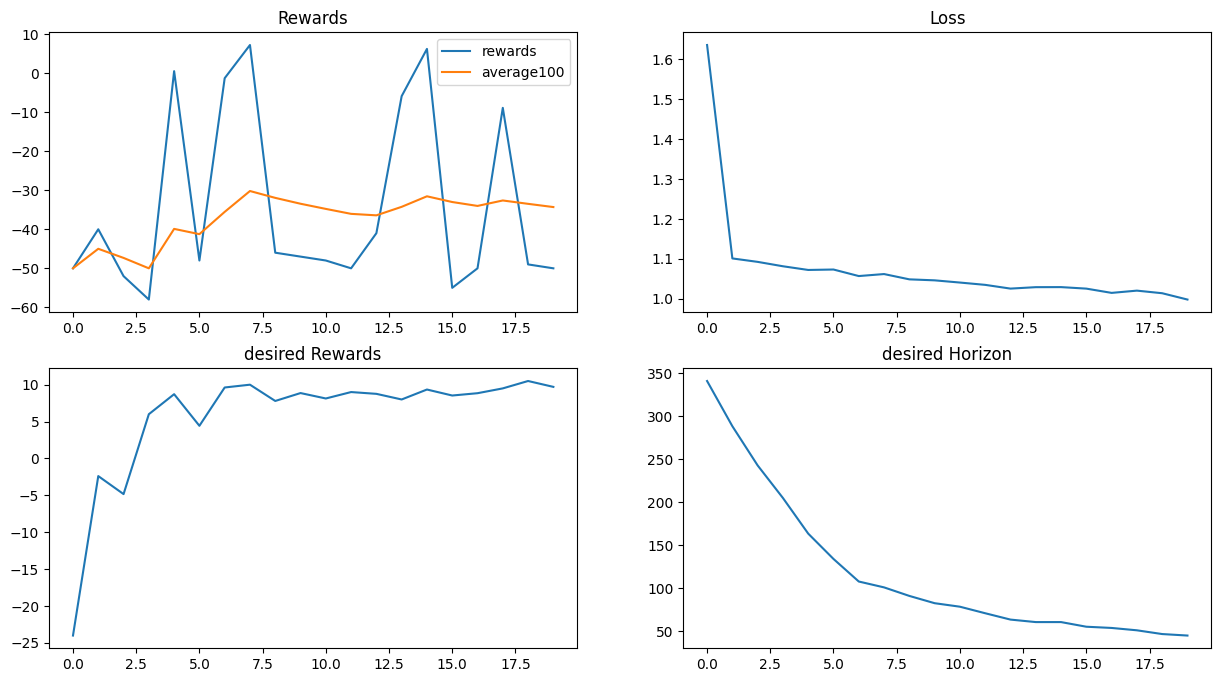

CPU times: total: 10min 43s
Wall time: 10min 51s


In [11]:
%%time
rewards, average, d, h, loss = run_upside_down(max_episodes=20)
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.title("Rewards")
plt.plot(rewards, label="rewards")
plt.plot(average, label="average100")
plt.legend()
plt.subplot(2,2,2)
plt.title("Loss")
plt.plot(loss)
plt.subplot(2,2,3)
plt.title("desired Rewards")
plt.plot(d)
plt.subplot(2,2,4)
plt.title("desired Horizon")
plt.plot(h)
plt.show()

In [12]:
# SAVE MODEL
name = "model_FourRoom_Auto.pth"
torch.save(bf.state_dict(), name)

In [13]:
## OBSERVE THE WEIGHTS after training
for p in bf.parameters():
    print(p) 

Parameter containing:
tensor([[[[ 0.0884, -0.0929, -0.0446],
          [ 0.0761, -0.1920,  0.1052],
          [-0.0555,  0.0845,  0.0132]],

         [[-0.0328,  0.0453,  0.0017],
          [ 0.0576, -0.0867, -0.0253],
          [-0.0337,  0.0115, -0.0162]],

         [[ 0.1594,  0.0521, -0.0789],
          [-0.1282, -0.0439, -0.0940],
          [-0.0766, -0.0058,  0.1002]]],


        [[[ 0.0698, -0.2087,  0.1057],
          [ 0.0282,  0.1696,  0.1215],
          [-0.1975, -0.2146, -0.1256]],

         [[ 0.1498, -0.0525,  0.0528],
          [-0.1074,  0.1590, -0.1246],
          [ 0.1270, -0.0360, -0.1573]],

         [[ 0.0792, -0.1202,  0.0362],
          [-0.0822, -0.0578, -0.2240],
          [-0.1010,  0.0803, -0.0761]]],


        [[[ 0.1470,  0.1236, -0.0170],
          [-0.1560,  0.0990,  0.0957],
          [-0.1724,  0.0885,  0.1528]],

         [[ 0.1594, -0.1444, -0.0670],
          [ 0.0125, -0.0094, -0.1722],
          [-0.1173,  0.0580, -0.0608]],

         [[ 0.0783, -0